In [2]:
import open3d as o3d
import numpy as np
import math
import matplotlib.pyplot  as plt
import pandas as pd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [31]:
mesh = o3d.io.read_triangle_mesh("./resampled3/Bottle/D00020.obj")

RuntimeError: [Open3D Error] (double __cdecl open3d::geometry::TriangleMesh::GetVolume(void) const) D:\a\Open3D\Open3D\cpp\open3d\geometry\TriangleMesh.cpp:1201: The mesh is not watertight, and the volume cannot be computed.


In [4]:
''' 
1. Surface Area
2. Compactness
3. 3D rectangularity
4. Diameter
5. Convexity
6. Eccentricity

A3: Angle between 3 random vertices
D1: Distance between barycenter and random vertex
D2: Distance between 2 random vertices
D3: Square root of area of triangle given 3 random vertices
D4: cube root of volume of tetrahedron formed by 4 random vertices
'''

' \n1. Surface Area\n2. Compactness\n3. 3D rectangularity\n4. Diameter\n5. Convexity\n6. Eccentricity\n\nA3: Angle between 3 random vertices\nD1: Distance between barycenter and random vertex\nD2: Distance between 2 random vertices\nD3: Square root of area of triangle given 3 random vertices\nD4: cube root of volume of tetrahedron formed by 4 random vertices\n'

In [5]:
# Volume
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

Vmesh = mesh
pcd = Vmesh.sample_points_poisson_disk(10000)

def reconstruct(a):
    try:
        Vmesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, a)
        Vmesh.compute_vertex_normals()
        V = Vmesh.get_volume()
        o3d.visualization.draw_geometries([Vmesh], mesh_show_back_face=True)
        return V
    except:
        return None

V = None
alpha = 0.2
while V == None:
    V = reconstruct(alpha)
    alpha += 0.05


[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh


In [6]:
# 1. Surface Area
S = mesh.get_surface_area()

S

0.6831987949115752

In [7]:
# 2. Compactness
c = S**3 / (36 * math.pi * V**2 )
c

2.2750416459443543

In [8]:
# 3. 3D rectangularity
obb = mesh.get_oriented_bounding_box()
Vobb = obb.volume()
R = V/Vobb

In [9]:
# 4. 3D Diameter
D = 0
verts = np.asarray(mesh.vertices)

for x1, y1, z1 in verts:
    for x2, y2, z2 in verts:
        currD = ((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)**0.5
        if D < currD:
            D = currD

D

1.0054848692214566

In [10]:
# 5. Convexity
CH = mesh.compute_convex_hull()
Vch = CH[0].get_volume()
C = V / Vch
C


0.9097453667913546

In [11]:
# 6. Eccentricity
cov = np.cov(verts.transpose())
eigenvalues, _ = np.linalg.eig(cov)
E =  min(eigenvalues) / max(eigenvalues)
E

0.03954283224463605

In [12]:
n = 100000
a3_sample = verts[np.random.randint(len(verts), size=(n, 3))]

a3_dist = []

for A, B, Cp in a3_sample:

    ab = A - B
    bc = Cp - B

    abVec = math.sqrt(sum(ab * ab))
    bcVec = math.sqrt(sum(bc * bc))

    try:        
        res = sum((ab / abVec) * (bc / bcVec))
        a3_dist.append(math.acos(res)*180.0/ math.pi)
    except:
        print("Failed:", A, B, Cp)

A3 = a3_dist

C:\Users\jelle\AppData\Local\Temp\ipykernel_4052\13391492.py:15: RuntimeWarning: invalid value encountered in divide
  res = sum((ab / abVec) * (bc / bcVec))


Failed: [ 0.45241499 -0.024691    0.03238   ] [-0.50748199 -0.004212   -0.057416  ] [ 0.45241499 -0.024691    0.03238   ]
Failed: [ 0.09437  -0.060373 -0.107609] [-0.42765999 -0.057729   -0.10816   ] [ 0.09437  -0.060373 -0.107609]
Failed: [-0.428029  0.06237  -0.101853] [-0.28328899 -0.123978    0.034199  ] [-0.428029  0.06237  -0.101853]
Failed: [-0.195629  0.107666  0.061323] [0.28360599 0.03591    0.037509  ] [-0.195629  0.107666  0.061323]
Failed: [0.483237 0.007044 0.030554] [0.301736 0.038701 0.029733] [0.483237 0.007044 0.030554]
Failed: [0.36684901 0.036353   0.01077   ] [ 0.15437999  0.002379   -0.092703  ] [0.36684901 0.036353   0.01077   ]
Failed: [ 0.47641599 -0.041544   -0.006363  ] [ 0.1078   -0.035624  0.118756] [ 0.47641599 -0.041544   -0.006363  ]
Failed: [0.13830701 0.082422   0.068768  ] [ 0.241099 -0.013325 -0.057624] [0.13830701 0.082422   0.068768  ]
Failed: [ 0.3382    0.038031 -0.019108] [-0.17084   0.121733  0.013236] [ 0.3382    0.038031 -0.019108]
Failed: [-

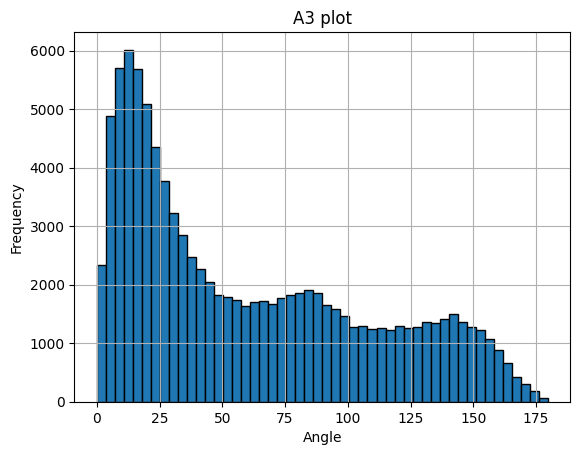

In [13]:
# Create a histogram
plt.hist(A3, bins=50, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.title('A3 plot')
plt.grid(True)

# Display the histogram
plt.show()

In [14]:

n = 100000
xb, yb, zb = np.mean(verts, axis=0)
d1_sample = verts[np.random.randint(len(verts), size=(n))]

d1_dist = []

for xs, ys, zs in d1_sample:
    d = ((xs - xb)**2 + (ys - yb)**2 + (zs - zb)**2)**0.5
    d1_dist.append(d)

D1 = d1_dist

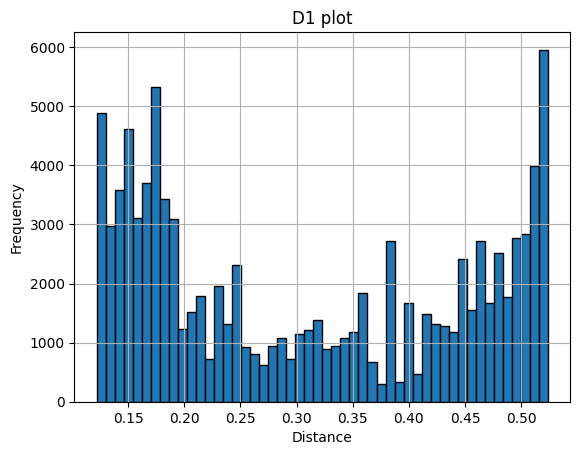

In [15]:
# Create a histogram
plt.hist(D1, bins=50, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('D1 plot')
plt.grid(True)

# Display the histogram
plt.show()

In [16]:
n = 100000
d2_sample1 = verts[np.random.randint(len(verts), size=(n))]
d2_sample2 = verts[np.random.randint(len(verts), size=(n))]


d2_dist = []

for i in range(n):
    xb, yb, zb = d2_sample1[i]
    xs, ys, zs = d2_sample2[i]
    d = ((xs - xb)**2 + (ys - yb)**2 + (zs - zb)**2)**0.5
    d2_dist.append(d)

D2 = d2_dist

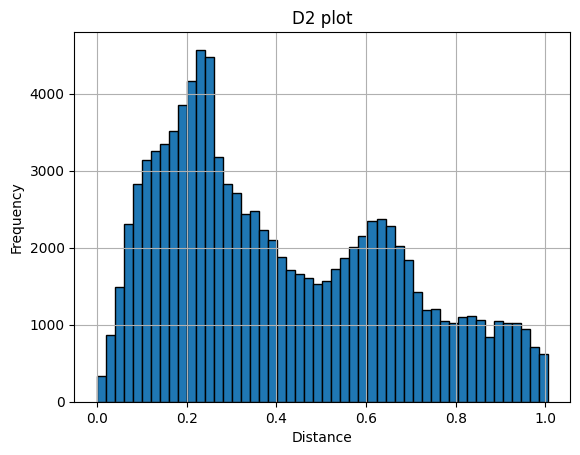

In [17]:
# Create a histogram
plt.hist(D2, bins=50, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('D2 plot')
plt.grid(True)

# Display the histogram
plt.show()

In [18]:
n = 100000
d3_sample1 = verts[np.random.randint(len(verts), size=(n))]
d3_sample2 = verts[np.random.randint(len(verts), size=(n))]
d3_sample3 = verts[np.random.randint(len(verts), size=(n))]


d3_dist = []

for i in range(n):
    A = d3_sample1[i]
    B = d3_sample2[i]
    Cp = d3_sample3[i]

    Xab, Yab, Zab = A - B
    Xac, Yac, Zac = A - Cp

    d = ((Yab * Zac - Zab * Yac)**2 + (Zab * Xac - Xab * Zac)**2 + (Xab * Yac - Yab * Xac)**2)**0.5
    d3_dist.append(d)

D3 = np.sqrt(d3_dist)


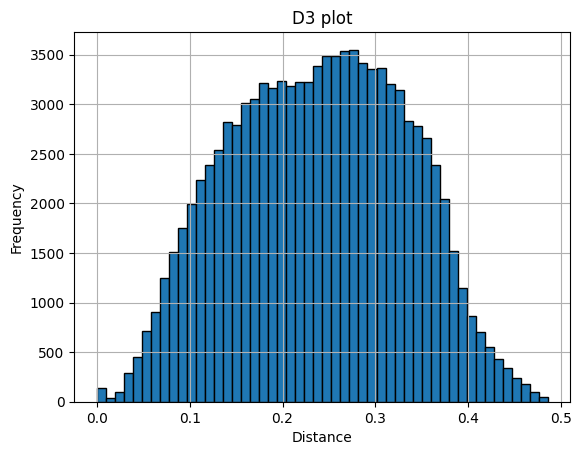

In [19]:
# Create a histogram
plt.hist(D3, bins=50, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('D3 plot')
plt.grid(True)

# Display the histogram
plt.show()

In [4]:
n = 100000
d4_sample1 = verts[np.random.randint(len(verts), size=n)]
d4_sample2 = verts[np.random.randint(len(verts), size=(n))]
d4_sample3 = verts[np.random.randint(len(verts), size=(n))]
d4_sample4 = verts[np.random.randint(len(verts), size=(n))]

d4_dist = []

def determinant_3x3(m):
    return (m[0][0] * (m[1][1] * m[2][2] - m[1][2] * m[2][1]) -
            m[1][0] * (m[0][1] * m[2][2] - m[0][2] * m[2][1]) +
            m[2][0] * (m[0][1] * m[1][2] - m[0][2] * m[1][1]))

for i in range(n):
    A = d4_sample1[i]
    B = d4_sample2[i]
    Cp = d4_sample3[i]
    Dp = d4_sample4[i]

    ab = A - B
    ac = A - Cp
    ad = A - Dp

    d = abs(determinant_3x3((ab,ac,ad)) / 6)
    d4_dist.append(d)

D4 = np.cbrt(d4_dist)

NameError: name 'verts' is not defined

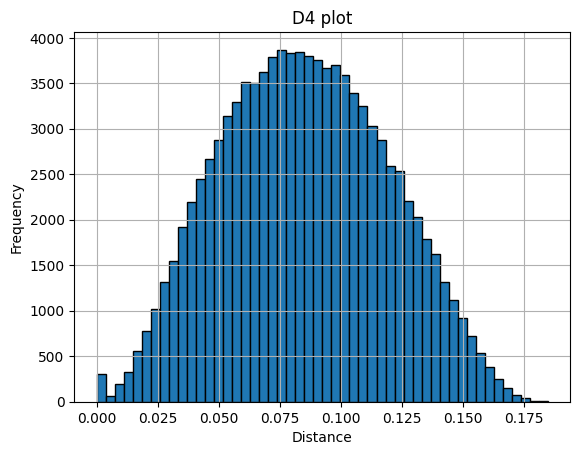

In [21]:
# Create a histogram
plt.hist(D4, bins=50, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('D4 plot')
plt.grid(True)

# Display the histogram
plt.show()

In [45]:
mesh = o3d.io.read_triangle_mesh("./m514_REMESHED.obj")

# Detect
triangles = np.asarray(mesh.triangles)
edges = []
for t1, t2, t3 in triangles:
    v1 = [t1, t2]
    v2 = [t2, t3]
    v3 = [t3, t1]

    v1.sort()
    v2.sort()
    v3.sort()

    if (v1 in edges):
        edges.remove(v1)
    else:
        edges.append(v1)
    
    if (v2 in edges):
        edges.remove(v2)
    else:
        edges.append(v2)

    if (v3 in edges):
        edges.remove(v3)
    else:
        edges.append(v3)

# Get Boundrys
bounds = []
while len(edges) > 0:
    bound = [edges[0]]
    edges.remove(edges[0])
    added = True
    while added:
        added = False
        for b in bound:
            for e in edges:
                if b[0] == e[0] or b[1] == e[0] or b[0] == e[1] or b[1] == e[1]:
                    edges.remove(e)
                    bound.append(e)
                    added = True
        
    bounds.append(bound)

# Get vertices
vertices = np.asarray(mesh.vertices)
bounds_verts = []
bounds_vertsi = []
for bound in bounds:
    bound_verts = []
    added = []
    for b1, b2 in bound:
        if b1 not in added:
            bound_verts.append(vertices[b1])
            added.append(b1)
        
        if b2 not in added:
            bound_verts.append(vertices[b2])
            added.append(b2)
    
    bounds_vertsi.append(added)
    bounds_verts.append(bound_verts)

# Create fans
new_vertices = np.copy(vertices)
new_triangles = np.copy(triangles)

for i in range(len(bounds)):
    barycenter = np.mean(bounds_verts[i], axis=0)
    bcenter = len(new_vertices)
    new_vertices = np.vstack([new_vertices, barycenter])
    for e1, e2 in bounds[i]:
        new_triangles = np.vstack([new_triangles, [e1, e2, bcenter]])

4

In [6]:
Surf = 0
Volu = 0

def determinant_3x3(m):
    return (m[0][0] * (m[1][1] * m[2][2] - m[1][2] * m[2][1]) -
            m[1][0] * (m[0][1] * m[2][2] - m[0][2] * m[2][1]) +
            m[2][0] * (m[0][1] * m[1][2] - m[0][2] * m[1][1]))

for t in new_triangles:
    a, b, c = new_vertices[t]
    o = np.mean(new_vertices, axis=0)
    Xab, Yab, Zab = a - b
    Xac, Yac, Zac = a - c

    Surf += ((Yab * Zac - Zab * Yac)**2 + (Zab * Xac - Xab * Zac)**2 + (Xab * Yac - Yab * Xac)**2)**0.5

    ab = a - o
    ac = b - o
    ad = c - o

    Volu += determinant_3x3((ab,ac,ad)) / 6

print(Surf, Volu)


NameError: name 'new_triangles' is not defined

In [5]:
mesh = o3d.io.read_triangle_mesh("./m514_REMESHED.obj")
triangles = np.asarray(mesh.triangles)
vertices = np.asarray(mesh.vertices)

Surf = 0
Volu = 0

for t in triangles:
    a, b, c = vertices[t]
    o = np.mean(vertices, axis=0)
    Xab, Yab, Zab = a - b
    Xac, Yac, Zac = a - c

    Surf += ((Yab * Zac - Zab * Yac)**2 + (Zab * Xac - Xab * Zac)**2 + (Xab * Yac - Yab * Xac)**2)**0.5

    ab = a - o
    ac = b - o
    ad = c - o

    Volu += determinant_3x3((ab,ac,ad)) / 6

print(Surf, Volu)


2.5157438433800365 0.03580398153616752
